In [27]:
import cv2
import numpy
import math
import numpy as np
import os

In [28]:
 #Filter HSV Image with given values
def filterImage( img, min_bgr, max_bgr):
    '''
    Input: HSV Image, 2 List of min and max HSV values
    Output: Black White Matrix/Image
    '''
    ## implement your filtering here.
    min_scal = np.array(min_bgr)
    max_scal = np.array(max_bgr)

    # img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    resultImg = cv2.inRange(img, min_scal, max_scal)
    resultImg = cv2.blur(resultImg,(1,1))

    return resultImg
        

In [29]:
def findCircle(imgMat):
        '''
        Input: Black Whit Image
        Return: List of center position of found Circle
        '''
        img = imgMat
        
        dp = 2
        minD = 120
        p1 = 255
        p2 = 27
        minS = 8
        maxS = 300
        circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, dp, minD, None, p1, p2, minS, maxS)


        if circles is None: # circles == None
            return None
        else:
            return np.reshape(circles,(circles.shape[1],circles.shape[2]))

In [30]:
def in_range_bgr(self,img,bgr_low,bgr_high):
        return cv2.inRange(img, np.array(bgr_low), np.array(bgr_high))

In [31]:
# Proces image to detect color blobs
def getBlobsData(image):
    '''
    Input: Image
    Return: numberOfBlobsFound , [List [center-pixels] of blobs]
    '''
    blobList = []
    low_orange = np.array([0, 0, 0])
    high_orange = np.array([225, 255, 255])
    low_blue = np.array([100, 180, 0])
    high_blue = np.array([140, 255, 255])
    low_green = np.array([36, 50, 100])
    high_green = np.array([86, 255, 255])


    ####### ORANGE ########
    orange_mask = cv2.inRange(image, low_orange, high_orange)
#     print(orange_mask)
    orange_circle = findCircle(orange_mask)
#     print(orange_circle)
    if orange_circle is not None:
        if orange_circle.shape == (1,3):
            print("\norange found\n")
            blobList.append(orange_circle)
#     ####### GREEN ##########
#     green_mask = cv2.inRange(image, low_green, high_green)
#     green_circle = findCircle(green_mask)
#     if green_circle is not None:
#         if green_circle.shape == (1,3):
#             print("\ngreen found")
#             blobList.append(green_circle)

#     ####### BLUE ##########
#     blue_mask = cv2.inRange(image, low_blue, high_blue)
#     blue_circle = findCircle(blue_mask)
#     if blue_circle is not None:
#         if blue_circle.shape == (1,3):
#             print("\nblue found")
#             blobList.append(blue_circle)

    blobsFound = len(blobList)

    return blobsFound, blobList

def drawCircles(circle_data):
    if not circle_data is None:
        img = np.zeros((320,400,3), np.uint8)
        for i in circle_data:
            print(i[0])
            if not i is None:
                cv2.circle(img,(int(i[0]),int(i[1])),int(i[2]),(255,255,255),1)
        # return cv.fromarray(img)
        return img
    else:
        print("NO CIRCLES")

In [32]:
def delete_background(im):
        """
        Finds contours on the image and changes the pixels outside these contours to black. 
        Input: bgr image
        Returns: returns hsv image 
        """
        # Find contours on image
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY,) 
#         print(gray)
        ret, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
        contours, hierarchy  = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  
#         print(contours)
        # Change pixels outside the contours to black
        stencil = np.zeros(im.shape).astype(im.dtype)
        cv2.fillPoly(stencil, contours, [255,255,255])
        result = cv2.bitwise_and(im, stencil)
        cv2.imwrite("result.png", result)

        return cv2.cvtColor(result, cv2.COLOR_BGR2HSV)


In [33]:
 def find_blobs(image):
        """
        Takes a picture, and makes background black.
        Returns hsv image.
        """
        
        image_hsv = delete_background(image)
        print(image_hsv)
#         cv2.imshow("wind",image_hsv)
        return getBlobsData(image_hsv)


In [34]:
def convertColourSpace(srcImage, conversion):
        dstImage = cv2.cvtColor(srcImage, conversion) # cv2.COLOR_RGB2RGBA)
        return dstImage

In [59]:
# RED BALL EDITION


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

images = load_images_from_folder('Traffic_light_data_ETHZ/red')
for i, image in enumerate(images):    
# last_image = cv2.imread('Traffic_light_data_ETHZ/red/b_br_yanberbot_0764.jpg')
    cv2.medianBlur(image, 3)
    hsv_conv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


    # because hue wraps up and to extract as many "red objects" as possible, I define lower and upper boundaries for brighter and for darker red shades
    bright_red_lower_bounds = (0, 150, 150)
    bright_red_upper_bounds = (10, 255, 255)
    bright_red_mask = cv2.inRange(hsv_conv_img, bright_red_lower_bounds, bright_red_upper_bounds)

    dark_red_lower_bounds = (160, 150, 130)
    dark_red_upper_bounds = (179, 255, 255)
    dark_red_mask = cv2.inRange(hsv_conv_img, dark_red_lower_bounds, dark_red_upper_bounds)

    # after masking the red shades out, I add the two images 
    weighted_mask = cv2.addWeighted(bright_red_mask, 1.0, dark_red_mask, 1.0, 0.0)

    # then the result is blurred
    blurred_mask = cv2.GaussianBlur(weighted_mask,(9,9),3,3)

    # some morphological operations (closing) to remove small blobs 
    erode_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilate_element = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
    eroded_mask = cv2.erode(blurred_mask,erode_element)
    dilated_mask = cv2.dilate(eroded_mask,dilate_element)


    # on the color-masked, blurred and morphed image I apply the cv2.HoughCircles-method to detect circle-shaped objects 
    detected_circles = cv2.HoughCircles(dilated_mask, cv2.HOUGH_GRADIENT, 1, 150, param1=100, param2=20, minRadius=1 ,maxRadius=200)
    if detected_circles is not None:
        for circle in detected_circles[0, :]:
            circled_orig = cv2.circle(image, (int(circle[0]), int(circle[1])), int(circle[2]), (0,255,0),thickness=3)
        cv2.imwrite("og_circ" + str(i) + ".png", circled_orig)
    else:
        cv2.imwrite("og" + str(i) +".png", image)


In [57]:
# RED TRAFFIC LIGHT EDITION


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

images = load_images_from_folder('Traffic_light_data_ETHZ/red')
for i, image in enumerate(images):    
# last_image = cv2.imread('Traffic_light_data_ETHZ/red/b_br_yanberbot_0764.jpg')
    cv2.medianBlur(image, 3)
    hsv_conv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


    # because hue wraps up and to extract as many "red objects" as possible, I define lower and upper boundaries for brighter and for darker red shades
    bright_red_lower_bounds = (100, 50, 220)
    bright_red_upper_bounds = (160, 160, 255)
    bright_red_mask = cv2.inRange(hsv_conv_img, bright_red_lower_bounds, bright_red_upper_bounds)

    dark_red_lower_bounds = (200, 150, 220)
    dark_red_upper_bounds = (255, 255, 255)
    dark_red_mask = cv2.inRange(hsv_conv_img, dark_red_lower_bounds, dark_red_upper_bounds)

    # after masking the red shades out, I add the two images 
    weighted_mask = cv2.addWeighted(bright_red_mask, 1.0, dark_red_mask, 1.0, 0.0)

    # then the result is blurred
    blurred_mask = cv2.GaussianBlur(weighted_mask,(9,9),3,3)

    # some morphological operations (closing) to remove small blobs 
    erode_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilate_element = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
    eroded_mask = cv2.erode(blurred_mask,erode_element)
    dilated_mask = cv2.dilate(eroded_mask,dilate_element)


    # on the color-masked, blurred and morphed image I apply the cv2.HoughCircles-method to detect circle-shaped objects 
    detected_circles = cv2.HoughCircles(dilated_mask, cv2.HOUGH_GRADIENT, 1, 150, param1=100, param2=20, minRadius=1 ,maxRadius=200)
    if detected_circles is not None:
        for circle in detected_circles[0, :]:
            circled_orig = cv2.circle(image, (int(circle[0]), int(circle[1])), int(circle[2]), (0,255,0),thickness=3)
        cv2.imwrite("og_traf_circ" + str(i) + ".png", circled_orig)
    else:
        cv2.imwrite("og_traf" + str(i) +".png", image)


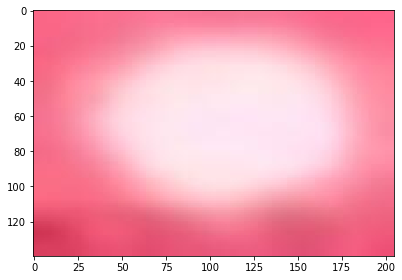

In [51]:
import sys
import skimage.io
from matplotlib import pyplot as plt

# read original image, in full color, based on command
# line argument
image = skimage.io.imread('red_crop')

# display the image
skimage.io.imshow(image)


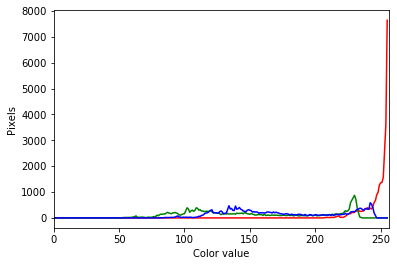

In [52]:
# tuple to select colors of each channel line
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        image[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color value")
plt.ylabel("Pixels")

plt.show()
